### Linear Regression
- Find the best fit for our data (regression problem)
- Assumptions:
    - Linearity
    - Independance
    - normality
    - homokedascity

<img src="images\\lin_reg.png " alt="Alt Text" width="400" height="300">

### Evaluating Lin Reg Model
- Mean Absolute Error (MAE)
    - Find the average of all the residual values: sum(abs(yi-y_i_hat))/n
- Mean Squared Error (MSE)
    - Find the average of all the squared residual values: sum((yi-y_i_hat)^2)/n
- Root Mean Squared Error (RMSE)
    - Find the average of all the squared residual values. then take the root: square_root(sum((yi-y_i_hat)^2)/n)
- Coeffcient of determination
    - R^2= 1-(RSS/TSS)
    - RSS= sum of the suared resdiuals = sum((yi-y_i_hat)^2)
    - TSS= total sum of squares of the difference between the points and mean (base case)= sum((yi-mean_y)^2)
    - If RSS<TSS then our prediction is better than the base case
    - If RSS>TSS then our prediction is worse
    - Ideally RSS->0 then R^2 will be 1

In [1]:
import pandas as pd
import sklearn.preprocessing as sklearn
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression


In [2]:
#Read the csv, rename columns, drop uncessary cols and convert categorical
df=pd.read_csv('data/SeoulBikeData.csv')
data_cols=['Date', 'bike_count', 'hour', 'temp', 'humidity',
       'wind', 'visibility', 'dew_pt_temp',
       'radiation', 'rain', 'snowfall', 'seasons',
       'holiday', 'functional']
df.columns=data_cols
df=df.drop(columns=['Date','holiday','seasons'])
df['functional']=df['functional'].map({'Yes':1,'No':0})

In [3]:
#Only look at noon data
df=df[df['hour']==12]
df=df.drop('hour',axis=1)

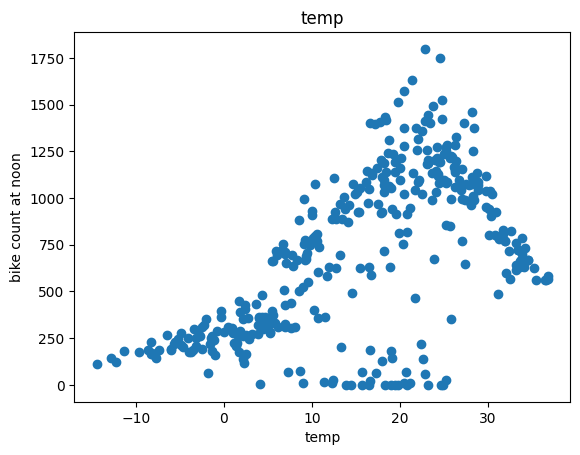

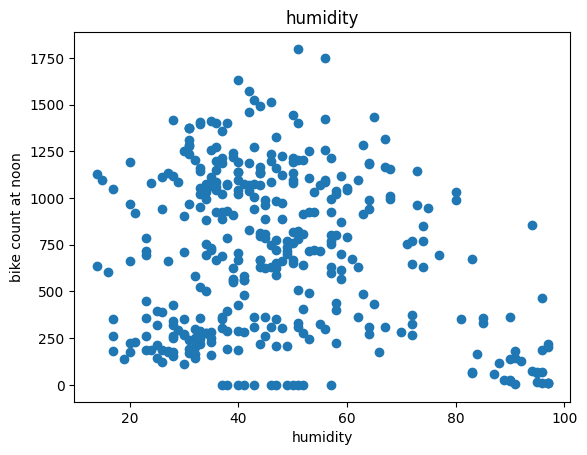

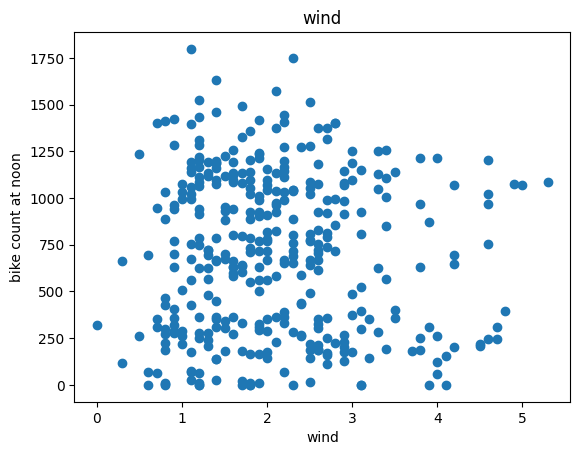

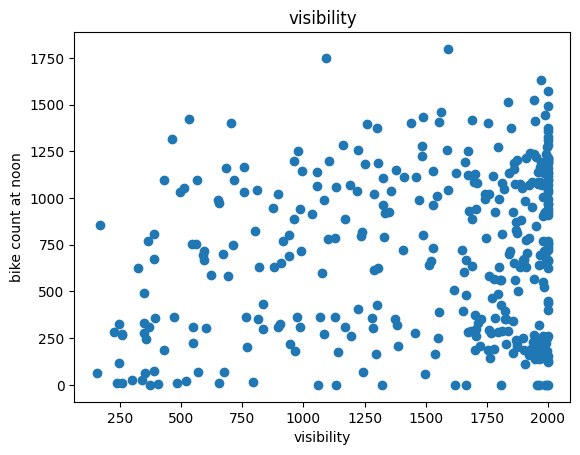

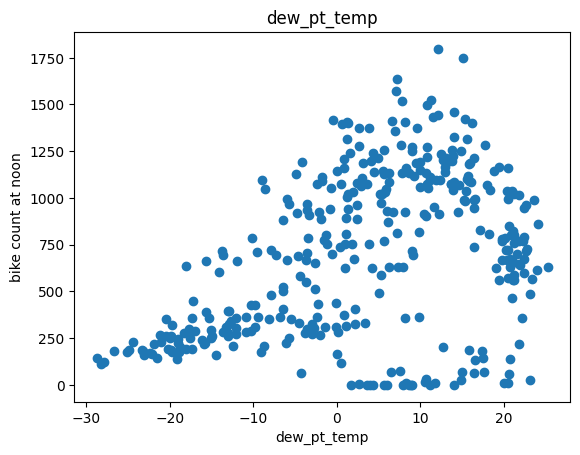

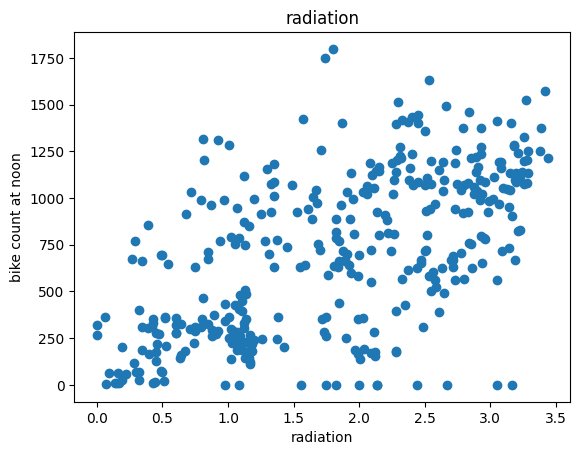

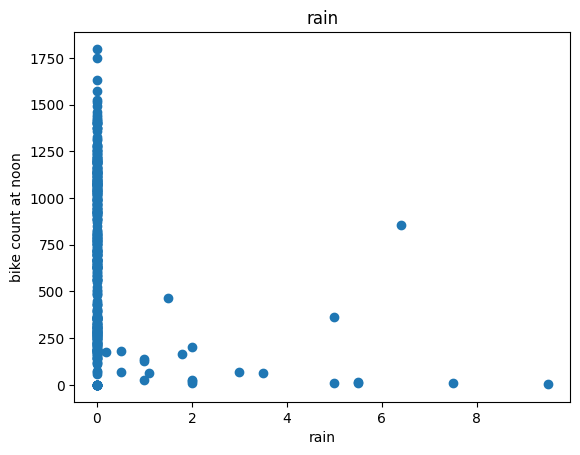

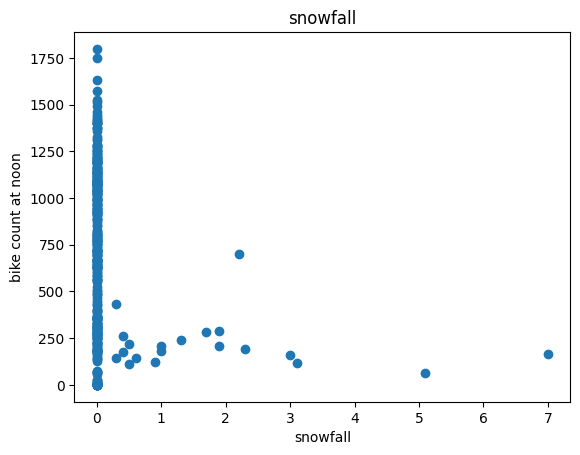

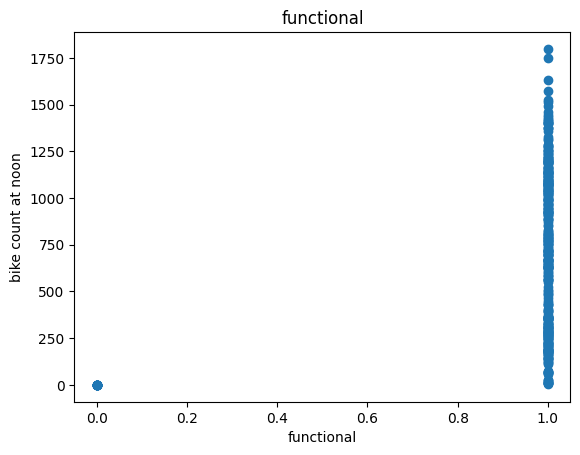

In [4]:
for col in df.columns[1:]:
    plt.scatter(df[col],df['bike_count'])
    plt.title(col)
    plt.ylabel('bike count at noon')
    plt.xlabel(col)
    plt.show()

In [5]:
df=df.drop(columns=['wind','visibility','functional'])

### Split to Train, Valid and Test

In [6]:
train,valid,test=np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

c:\Users\abhip\OneDrive\Documents\GitHub\envs\ml-libs\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
def get_xy(df,y_label,x_labels=None):
    data_frame=copy.deepcopy(df)

    if not x_labels:
        X_vals=data_frame[[c for c in data_frame.columns if c!=y_label]].values
    elif len(x_labels)==1:
        X_vals=data_frame[x_labels[0]].values.reshape(-1,1)

    else:
        X_vals=data_frame[x_labels].values

    y_vals=data_frame[y_label].values.reshape(-1,1)
    data=np.hstack((X_vals,y_vals))
    return data,X_vals,y_vals
    



In [8]:
_,X_train,y_train=get_xy(train,'bike_count')
_,X_valid,y_valid=get_xy(valid,'bike_count')
_,X_test,y_test=get_xy(test,'bike_count')


In [9]:
_,X_train_temp,y_train_temp=get_xy(train,'bike_count',['temp'])
_,X_valid_temp,y_valid_temp=get_xy(valid,'bike_count',['temp'])
_,X_test_temp,y_test_temp=get_xy(test,'bike_count',['temp'])


In [10]:
temp_reg=LinearRegression()
temp_reg.fit(X_train_temp,y_train )


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
print(temp_reg.coef_,temp_reg.intercept_)
print(temp_reg.score(X_test_temp,y_test_temp))

[[19.86403295]] [380.89829757]
0.33720409640210924


Text(0.5, 0, 'temp')

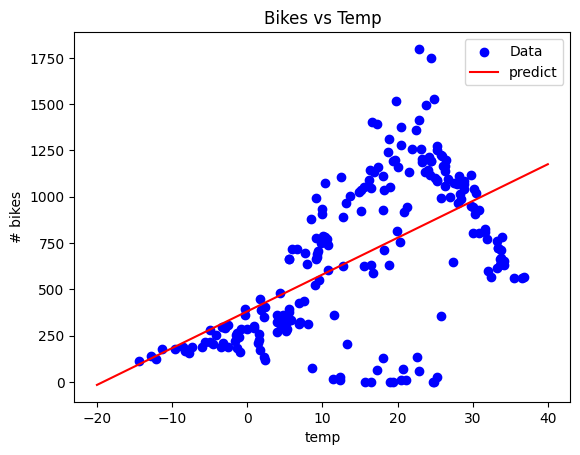

In [12]:
plt.scatter(X_train_temp,y_train_temp, label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_reg.predict(np.array(x).reshape(-1,1)),
         label='predict',color='red')
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('# bikes')
plt.xlabel('temp')

### Multiple Lin Reg

In [13]:
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train )
print(lin_reg.score(X_test,y_test))

0.44966787762638694


### Reg with NN

#### Examining Temp

In [14]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

temp_nn=tf.keras.Sequential(
    [temp_normalizer,
    tf.keras.layers.Dense(1),]

)
temp_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')




c:\Users\abhip\OneDrive\Documents\GitHub\envs\ml-libs\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
history=temp_nn.fit(X_train_temp.reshape(-1),y_train_temp,verbose=0,epochs=1000,validation_data=(X_valid_temp,y_valid_temp))

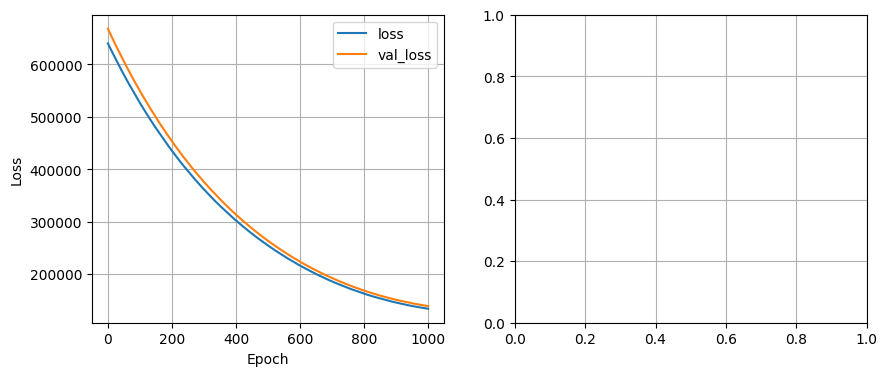

In [16]:
def plot_history(history,loss='loss',accuracy='accuracy'):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
    ax1.plot(history.history[loss],label='loss')
    ax1.plot(history.history['val_'+loss],label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # ax2.plot(history.history[accuracy],label='accuracy')
    # ax2.plot(history.history['val_'+accuracy],label='val_accuracy')
    # ax2.set_xlabel('Epoch')
    # ax2.set_ylabel('Accuracy')
    # ax2.legend()
    ax2.grid(True)

    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='accuracy')
    plt.plot(history.history['val_accuracy'],label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history,'loss','mean_squared_error')
# plot_accuracy(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Text(0.5, 0, 'temp')

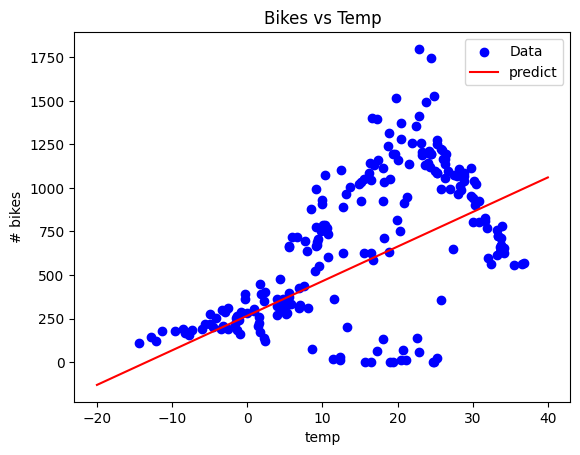

In [17]:
plt.scatter(X_train_temp,y_train_temp, label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_nn.predict(np.array(x).reshape(-1,1)),
         label='predict',color='red')
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('# bikes')
plt.xlabel('temp')

In [18]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model=tf.keras.Sequential(
    [temp_normalizer,
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),

    tf.keras.layers.Dense(1)]

)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')




c:\Users\abhip\OneDrive\Documents\GitHub\envs\ml-libs\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
history=nn_model.fit(X_train_temp.reshape(-1),y_train_temp,verbose=0,epochs=100,validation_data=(X_valid_temp,y_valid_temp))

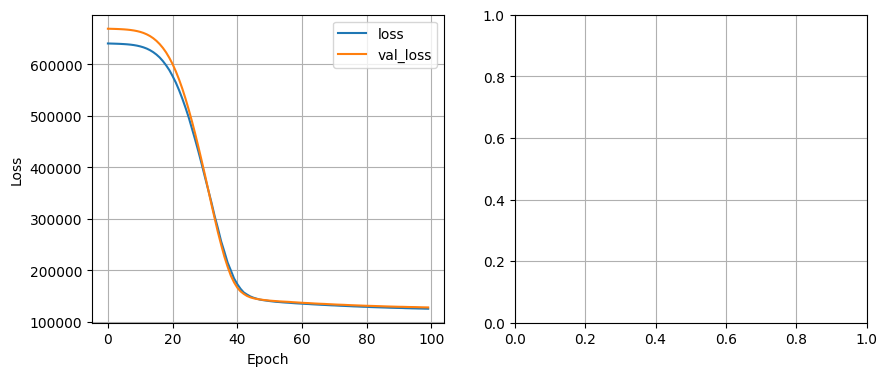

In [20]:
plot_history(history,'loss')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Text(0.5, 0, 'temp')

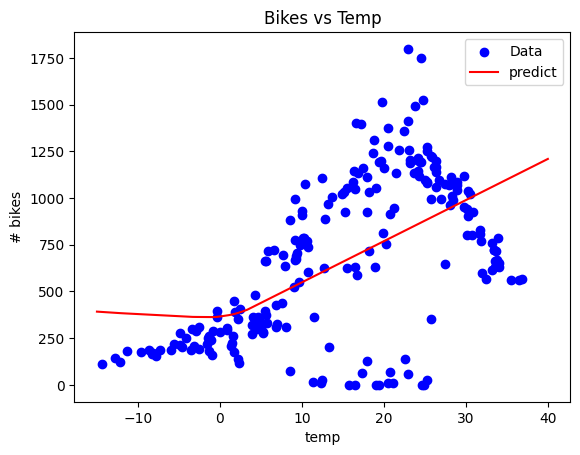

In [21]:
plt.scatter(X_train_temp,y_train_temp, label='Data',color='blue')
x=tf.linspace(-15,40,100)
plt.plot(x,nn_model.predict(np.array(x).reshape(-1,1)),
         label='predict',color='red')
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('# bikes')
plt.xlabel('temp')

#### Examining all

In [27]:
all_normalizer=tf.keras.layers.Normalization(input_shape=(6,),axis=-1)
all_normalizer.adapt(X_train)

all_nn_model=tf.keras.Sequential(
    [all_normalizer,
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),

    tf.keras.layers.Dense(1,activation='relu')]

)
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')




c:\Users\abhip\OneDrive\Documents\GitHub\envs\ml-libs\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


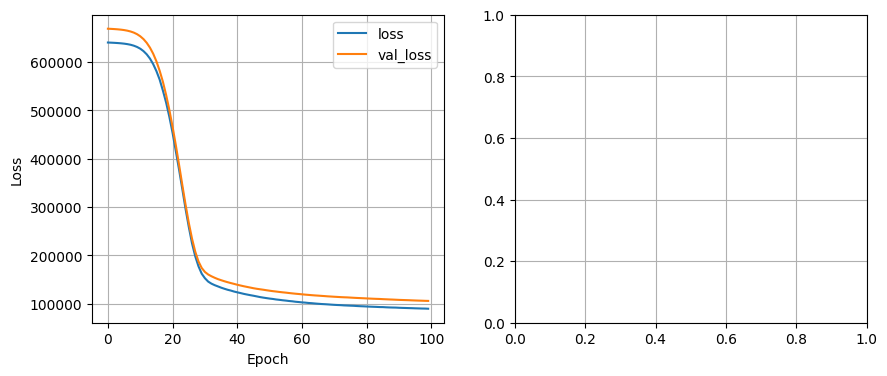

In [28]:
history=all_nn_model.fit(X_train,y_train,verbose=0,epochs=100,validation_data=(X_valid,y_valid))
plot_history(history)

In [29]:
## Calculating MSE for both linear and NN models
y_pred_lr=lin_reg.predict(X_test)
y_pred_nn=all_nn_model.predict(X_test)

def MSE(y_pred,y_real):
    return (np.square(y_pred-y_real)).mean()

print('lin_reg MSE: ', MSE(y_pred_lr,y_test))
print('NN MSE: ', MSE(y_pred_nn,y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
lin_reg MSE:  111596.36367868306
NN MSE:  112672.66075014458


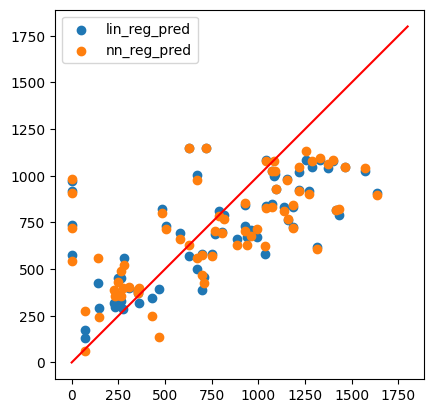

In [34]:
import matplotlib.pyplot as plt
ax=plt.axes(aspect='equal')
plt.scatter(y_test,y_pred_lr,label='lin_reg_pred')
plt.scatter(y_test,y_pred_nn,label='nn_reg_pred')

# plt.xlabel('true_val')
# plt.ylabel('lin_reg_pred')
lims=[0,1800]

plt.legend()

_=plt.plot(lims,lims,c='red')